In [144]:
# library and module imports for data retrieval and munging
import sys
import warnings
sys.path.append("../src/pipeline")
from utils import query_utils as query
from utils import gait_features_utils as gproc
import synapseclient as sc
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# extra commands
sns.set_style("darkgrid")
sns.set_context("paper")
warnings.simplefilter("ignore")

# some ML (scikit & xgboost) library imports for modelling
from xgboost import XGBClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import (train_test_split, learning_curve, GridSearchCV, cross_val_score, validation_curve)
import sklearn.metrics as metrics
from sklearn.metrics import (classification_report, confusion_matrix, roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.linear_model import (LogisticRegression, SGDClassifier)
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.feature_selection import RFECV, SelectKBest, chi2, SelectFromModel, RFE
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

# magic commands
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# ML Model Performance

This notebook will explore several contemporary ML models that can be fitted to the featurized gait dataset (healthcode aggregated). First, split the dataset into 80%-20% (train-test) where the best parameter will based on 10-fold cross validation.

## Retrieve Data

#### Global Variables

In [3]:
WALKING_GROUPED_FEATURES = "syn21626482"
MATCHED_DEMOGRAPHICS = "syn21614563"
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



### Helper Functions

#### a. CV-Model Fitting Function

In [100]:
# helper functions
def logreg_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(RandomForestClassifier(n_estimators = 1000,
                                                                   random_state  = 100))),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state = 100))
        ])
    param = [{'feature_selection__threshold' : ["1.1*median", "median"], 
                'classifier__penalty': ['l2']}, 
             {'feature_selection__threshold' : ["1.1*median", "median"], 
                'classifier__penalty': ['l1']}]
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV

def xgb_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(RandomForestClassifier(n_estimators = 100,
                                                            random_state  = 100))),
        ('classifier', XGBClassifier(seed = 100))
        ])
    param = {
        'feature_selection__threshold' : ["median", "1.1*median"], 
        "classifier__learning_rate" : [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [5, 10, 20, 50],
        'classifier__max_depth':[3, 6, 10]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV
    

def gradientboost_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = RandomForestClassifier(n_estimators = 100,
                                                                              random_state  = 100))),
        ('classifier', GradientBoostingClassifier(random_state = 100))
        ])
    param = {
        'feature_selection__threshold' : ["median", "1.1*median"],
        'classifier__max_depth':[3,6,10],
        'classifier__learning_rate': [0.01, 0.05, 0.1],
        "classifier__n_estimators"  : [5, 10, 20, 50]
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param , 
                      scoring= "roc_auc", n_jobs = -1, 
                      cv = 10, verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV


def randomforest_fit(X_train, y_train):
    pipe = Pipeline(steps=[
        ("feature_selection", SelectFromModel(estimator = RandomForestClassifier(n_estimators = 100 ,
                                                                              random_state = 100))),
        ('classifier', RandomForestClassifier(random_state = 100))
    ])
    param = {
        'feature_selection__threshold' : ["median", "1.1*median"], 
        'classifier__n_estimators'  : [5, 10, 20, 50],
        'classifier__min_samples_split':[2, 3],
    }
    CV = GridSearchCV(estimator = pipe, param_grid = param, 
                      scoring= "roc_auc", n_jobs = -1, cv = 10, 
                      verbose = True, refit = True)
    CV.fit(X_train, y_train)
    return CV

#### b. Model Results & Visualization Function

In [107]:
def get_results_dataframe(X_test, y_test, *models):
    data_dict = {}
    data_dict["model"] = []
    data_dict["parameter"] = []
    data_dict["roc-auc-cv"] = []
    data_dict["roc-auc-test"] = []
    data_dict["log-loss-test"] = []
    data_dict["f1-score-test"] = []
    for model in models:
        try:
            data_dict["model"].append(type(model.best_estimator_["classifier"]).__name__)
            data_dict["parameter"].append(model.best_params_)
            data_dict["roc-auc-cv"].append(model.best_score_)
        except:
            data_dict["model"].append(type(model).__name__)
            data_dict["parameter"].append(np.NaN)
            data_dict["roc-auc-cv"].append(np.NaN)
        y_true, y_pred = y_test, model.predict(X_test)
        data_dict["roc-auc-test"].append(metrics.roc_auc_score(y_true, y_pred))
        data_dict["log-loss-test"].append(metrics.log_loss(y_true, y_pred))
        data_dict["f1-score-test"].append(metrics.f1_score(y_true, y_pred))
    data = pd.DataFrame(data_dict)
    return data


def visualize_feature_importances(X_train, *models):
    for model in models:
        try:
            features = model.best_estimator_["classifier"].feature_importances_
        except:
            features = model.best_estimator_["classifier"].coef_[0]

        series = np.abs(pd.Series(data = features, 
                            index = X_train.columns[model.best_estimator_["feature_selection"].get_support()]))\
                            .sort_values(ascending = True).tail(20)
        plt.figure(figsize = (8,5))
        plt.title("Feature Importances based base on %s"%type(model.best_estimator_["classifier"]).__name__)
        series.plot(kind = "barh")
        plt.show()
        

def plot_roc_auc_curve(X_test, y_test, *models):
    plt.figure(figsize = (10,10))
    for model in models:
        model_name = type(model.best_estimator_["classifier"]).__name__
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        y_pred = model.predict(X_test_impute)
        for i in range(2):
            fpr[i], tpr[i], _ = roc_curve(y_test, y_pred)
            roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[1], tpr[1], label='%s ROC curve (area = %0.2f)' % (model_name, roc_auc[1] ))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label = "Random Guess (area = 0.5)")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend()
    plt.show()
    

def plot_learning_curves(X_train, y_train, *models):
    for model in models:
        try:
            estimator = model.best_estimator_
            model_name = type(model.best_estimator_["classifier"]).__name__
        except:
            estimator = model
            model_name = type(model).__name__
        train_sizes, train_scores, valid_scores = learning_curve(estimator, 
                                                                X_train, y_train, 
                                                                scoring = "roc_auc", 
                                                                cv = 5, random_state = 100, 
                                                                train_sizes = np.linspace(0.1, 1, 10))
        pd.DataFrame(data = {"train_scores": np.mean(train_scores, axis = 1), 
                             "valid_scores": np.mean(valid_scores, axis = 1)}, index = train_sizes).plot(figsize = (8,5))
        plt.ylabel("roc-auc")
        plt.title("%s Learning Curve"%model_name)
        plt.xlabel("Training Size")
        plt.show()

#### Preliminary Cleanups

In [102]:
# get data
data = query.get_file_entity(syn, WALKING_GROUPED_FEATURES )
demographic = query.get_file_entity(syn, MATCHED_DEMOGRAPHICS)


data = data[[feat for feat in data.columns if ("filepath" not in feat) 
             and ("window" not in feat) 
             and ("steps" not in feat) 
             and (feat != "index")
             and ("valrange" not in feat)]]


# filter datasets
data = data[(data["test_type"] == "walking") & 
            (data["age"] > 0) & 
            (data["table_version"] != "MPOWER_PASSIVE") &
            (data["class"] != "MS")]

# merge inner
data = pd.merge(
    demographic[["healthCode"]], data, on = "healthCode", how = "inner")

data = data.set_index("healthCode")

# clean sparse feature
data = data[data.columns[data.isnull().mean() < 0.2]]

# cols of choice
metadata_cols = ["test_type", "phoneInfo", "age", 
                 "gender", "table_version", 
                 "nrecords", "class"]
feat_cols = [feat for feat in data.columns if (feat not in metadata_cols)]

### 1. Impute missing data on training using MICE Model (Iterative Imputer)

In [110]:
train = data[feat_cols]
target = data["class"].map({"PD":1, "control":0})

# split train test split
X_train, X_test, y_train, y_test = train_test_split(
    train, target,                                          
    test_size = 0.2,                                
    random_state = 100)

imputer = IterativeImputer(
    random_state=100, 
    initial_strategy = "median")\
    .fit(X_train)

X_train_impute = imputer.fit_transform(X_train)
X_test_impute = imputer.fit_transform(X_test)

### 2. Model Performances

#### a. Initial Model

In [138]:
init_lr_model = LogisticRegression(random_state = 100).fit(X_train_impute, y_train)
init_rf_model = RandomForestClassifier(random_state = 100, 
                                       n_estimators = 5).fit(X_train_impute, y_train)
init_gb_model = GradientBoostingClassifier(random_state = 100, 
                                           n_estimators = 5).fit(X_train_impute, y_train)
init_xgb_model = XGBClassifier(random_state = 100, 
                               n_estimators = 5).fit(X_train_impute, y_train, verbose=True)
init_etree_model = ExtraTreesClassifier(random_state = 100, 
                               n_estimators = 5).fit(X_train_impute, y_train)
init_adaboost_model = AdaBoostClassifier(random_state = 100, 
                               n_estimators = 5).fit(X_train_impute, y_train)
init_sgd_model = SGDClassifier(random_state = 100).fit(X_train_impute, y_train)
init_svc_model = SVC(random_state = 100).fit(X = X_train_impute, y = y_train)
init_knn_model = KNeighborsClassifier().fit(X = X_train_impute, y = y_train)
init_gnb_model = GaussianNB().fit(X = X_train_impute, y = y_train)
init_LDA_model = LinearDiscriminantAnalysis().fit(X = X_train_impute, y = y_train)
init_QDA_model = QuadraticDiscriminantAnalysis().fit(X = X_train_impute, y = y_train)

get_results_dataframe(X_test_impute, y_test, 
                      init_xgb_model,
                     init_lr_model,
                     init_gb_model,
                     init_rf_model, 
                     init_etree_model,
                     init_adaboost_model, 
                    init_sgd_model, 
                    init_svc_model, 
                      init_knn_model, 
                      init_gnb_model, 
                      init_LDA_model,
                     init_QDA_model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,XGBClassifier,NaN,NaN,0.635802,12.559711,0.611511
1,LogisticRegression,NaN,NaN,0.636420,12.792331,0.635762
2,GradientBoostingClassifier,NaN,NaN,0.626543,12.908596,0.604982
3,RandomForestClassifier,NaN,NaN,0.640123,12.559730,0.630137
4,ExtraTreesClassifier,NaN,NaN,0.572840,14.885603,0.564626
5,AdaBoostClassifier,NaN,NaN,0.624691,13.257513,0.629870
6,SGDClassifier,NaN,NaN,0.542593,14.652855,0.275862
7,SVC,NaN,NaN,0.598765,13.838941,0.573477
8,KNeighborsClassifier,NaN,NaN,0.539506,15.932233,0.519298
9,GaussianNB,NaN,NaN,0.617284,12.908555,0.557769


After assessing the initial model performance using commonly used classification models, we can see that the top performers are the LogisticRegression, GradientBoostingClassifier, RandomForestClassifier and the XGBoost. Thus to simplify our model choice, we will try to optimize these 4 models through 10-fold cross validation grid search on the hyperparameter tuning. 

#### b. (Slightly) Grid Searched CV Model

In [139]:
 ## models ##
cv_lr_model = logreg_fit(X_train_impute, y_train)
cv_rf_model = randomforest_fit(X_train_impute, y_train)
cv_gb_model = gradientboost_fit(X_train_impute, y_train)
cv_xgb_model = xgb_fit(X_train_impute, y_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   37.9s finished


Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   17.3s finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.6min finished


Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   44.2s
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed:  1.3min finished


### 3. Prediction Results Dataframe

In [140]:
get_results_dataframe(X_test_impute, y_test, 
                      cv_xgb_model, 
                      cv_lr_model, 
                      cv_rf_model, 
                      cv_gb_model)

,model,parameter,roc-auc-cv,roc-auc-test,log-loss-test,f1-score-test
0,XGBClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.685569,0.620988,13.024880,0.591241
1,LogisticRegression,"{'classifier__penalty': 'l1', 'feature_selecti...",0.663722,0.640123,12.676038,0.640264
2,RandomForestClassifier,"{'classifier__min_samples_split': 2, 'classifi...",0.666300,0.638272,12.559722,0.622378
3,GradientBoostingClassifier,"{'classifier__learning_rate': 0.1, 'classifier...",0.682751,0.597531,13.955244,0.580420


The ML prediction shows that all models are consistently above an AUC of .65 on the 10-fold cross validation, which is a good thing, as it indicates that our features are able to give enough signal for the model to capture. However, In choosing which model to use, we will then assess the model learning curve to see which model is able to generalize without overfitting.

### 4. Feature Importances

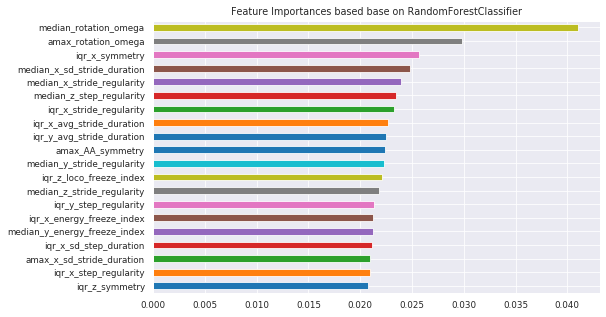

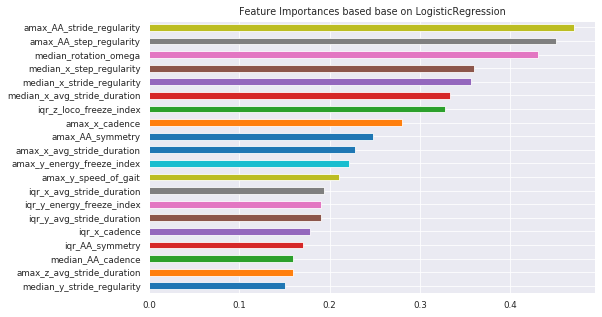

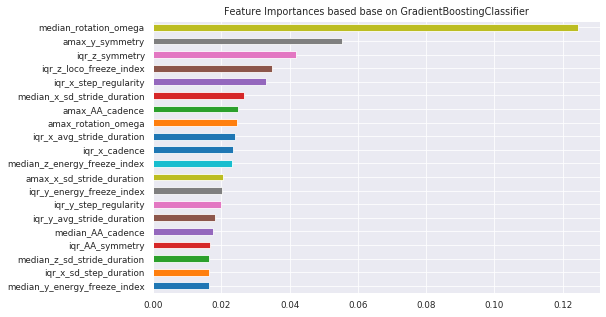

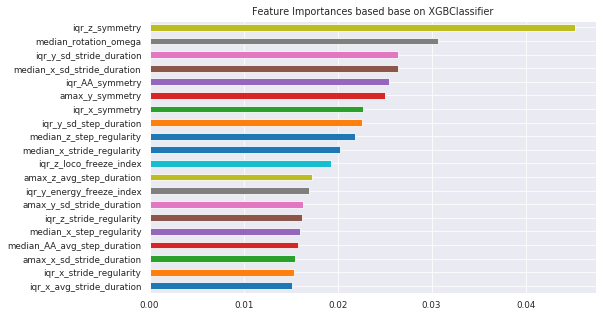

In [141]:
visualize_feature_importances(X_train, cv_rf_model, 
                              cv_lr_model, 
                              cv_gb_model, 
                              cv_xgb_model)

### 5. ROC-AUC Curve

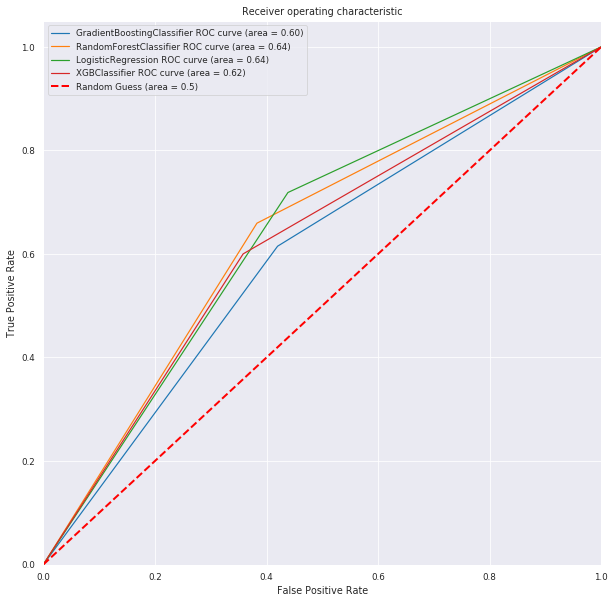

In [142]:
plot_roc_auc_curve(X_test_impute, y_test, 
                   cv_gb_model, 
                   cv_rf_model, 
                   cv_lr_model, 
                   cv_xgb_model)

### 6. Learning Curve

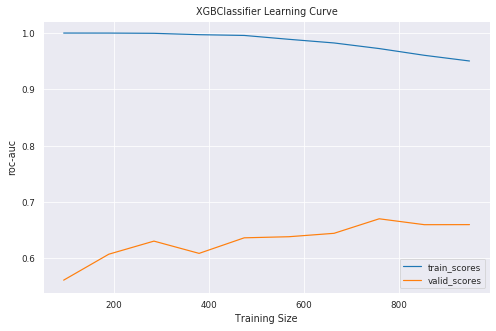

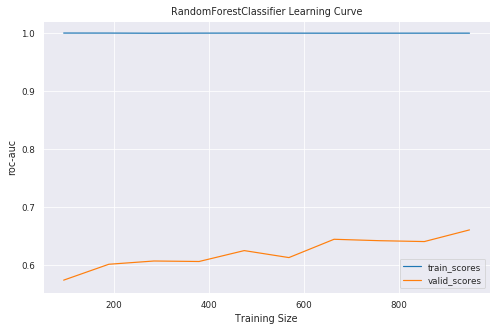

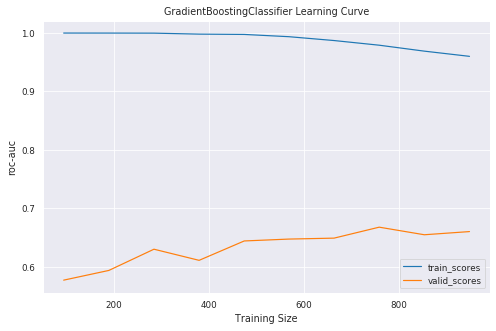

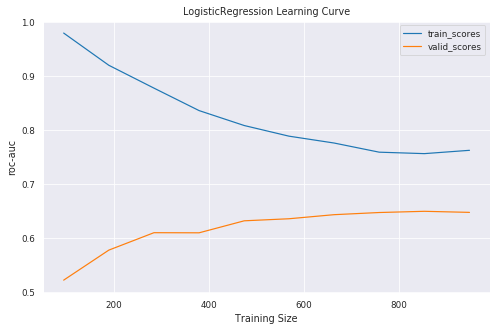

In [143]:
plot_learning_curves(X_train_impute, y_train, 
                     cv_xgb_model,
                     cv_rf_model,
                     cv_gb_model,
                     cv_lr_model
                     )

From the learning curve above, we can see that most of the ensemble models are highly overfitted, as we can see that the gap between the training scores and the validation scores are far apart from each other, which indicates that our model will have high variance when used in production. Assessing from the learning curve, it seems that our logistic regression actually generalizes the best as the variance between the training and validation sets is not far apart from each other.

### Results:


Our end result from this model analysis is that for ensemble models, it seems that the data seems to overfit really easily despite only using a low number of estimators, which could practically mean that we may lack samples to be trained on. However, simple linear model like logistic regression is able to predict and generalize the model without severly overfitting the data. 

Next, is that we will try to monitor these 4 models and assess the performance on new data streams. 